### Physics-Informed Beer Fermentation Modelling (PINNs)




In [1]:
# Python dependencies # Standard libraries
import os      # Operating system interfaces (file paths, directories)
import time    # Time-related functions
import math    # Mathematical functions
import json    # For handling JSON data

# Data handling and plotting
import numpy as np             # Numerical computing
import pandas as pd            # Data manipulation
import matplotlib.pyplot as plt # Plotting and visualization

# PyTorch libraries for deep learning
import torch
import torch.nn as nn          # Neural network modules
import torch.nn.functional as F # Activation functions and other functional ops
from torch.autograd import grad # For computing gradients (useful in PINNs or custom losses)

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [3]:
# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [4]:
# Load dataset
file_path = "data/02 - IPA - SA-05.csv"  # Fermentation Dataset
df = pd.read_csv(file_path)

# Display info
print("First 5 rows:\n", df.head())
print("\nLast 5 rows:\n", df.tail())
print("\nColumns:\n", df.columns)
print("\nDataset shape:", df.shape)

First 5 rows:
        Timestamp (BST)  Hours from Pitch  DO (mg/L)    pH  Gravity (°P)  \
0  2022-06-17 16:00:00              0.01       1.72  5.77          12.0   
1  2022-06-17 16:10:00              0.18       1.69  5.76          12.0   
2  2022-06-17 16:20:00              0.35       1.70  5.76          12.0   
3  2022-06-17 16:30:00              0.52       1.60  5.76          12.0   
4  2022-06-17 16:40:00              0.68       1.54  5.76          12.0   

   Pressure (Bar)  Fluid Temp (°C)  Ambient Temp (°C)  Conductivity (uS/cm)  
0            0.07             22.4               20.0                2418.0  
1            0.07             22.2               20.0                2424.0  
2            0.07             22.1               20.0                2427.0  
3            0.07             22.1               19.0                2424.0  
4            0.07             22.1               19.0                2427.0  

Last 5 rows:
           Timestamp (BST)  Hours from Pitch  DO (mg

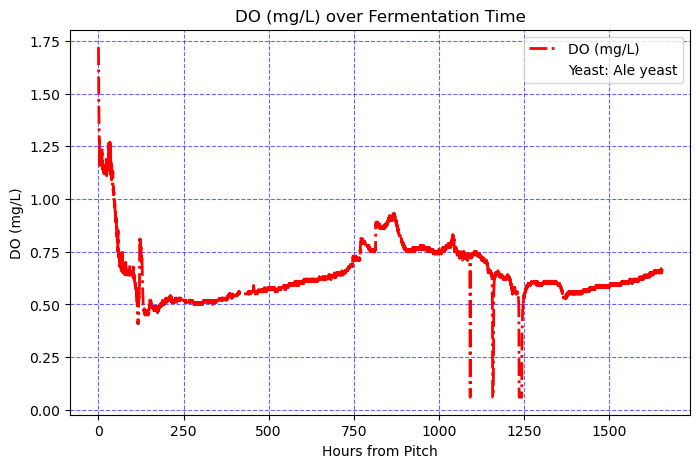

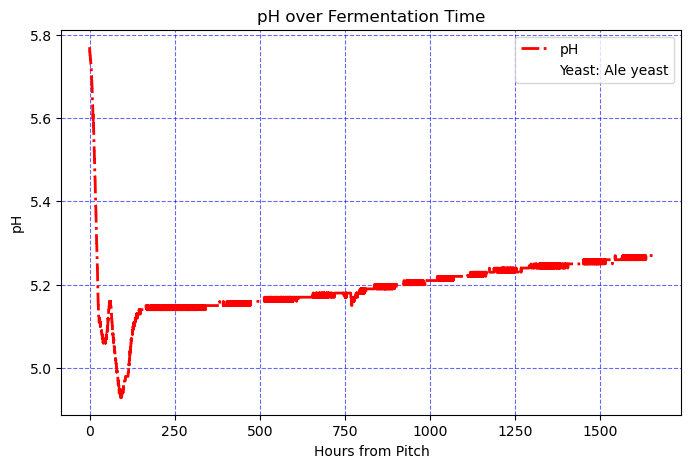

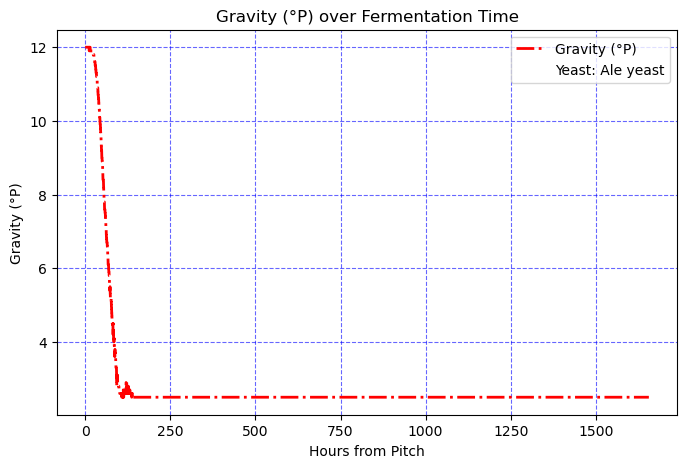

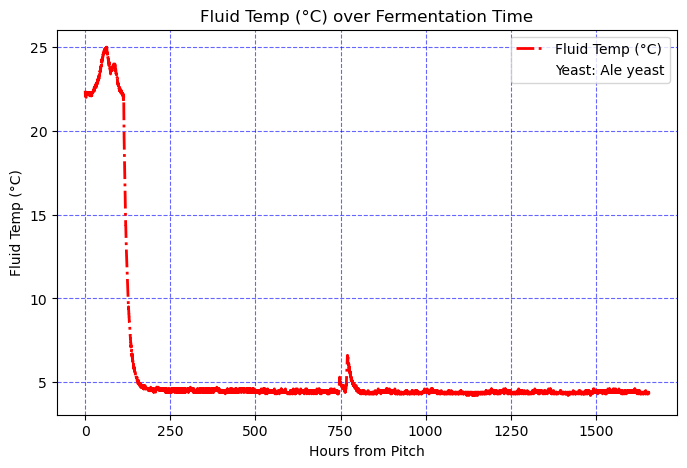

In [5]:
# Convert timestamp to datetime
df["Timestamp (BST)"] = pd.to_datetime(df["Timestamp (BST)"])

# Fermentation variables ["DO (mg/L)", "pH", "Gravity (°P)", "Fluid Temp (°C)"]
variables = ["DO (mg/L)", "pH", "Gravity (°P)", "Fluid Temp (°C)"]

# Yeast type
yeast_type = "Ale yeast"

# Plots | Figures
for var in variables:
    plt.figure(figsize=(8, 5))
    
    # Main variable line
    plt.plot(df["Hours from Pitch"], df[var], label=var, linewidth=2, color="red", linestyle="-.")
    
    # Add yeast type as a legend entry (invisible plot)
    plt.plot([], [], ' ', label=f"Yeast: {yeast_type}")
    
    plt.xlabel("Hours from Pitch")
    plt.ylabel(var)
    plt.title(f"{var} over Fermentation Time")
    plt.grid(True, linestyle="--", color="blue", alpha=0.6)
    plt.legend()
    plt.show()


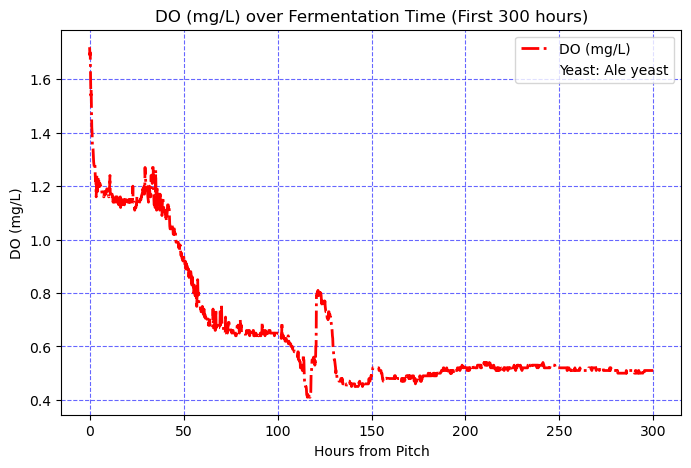

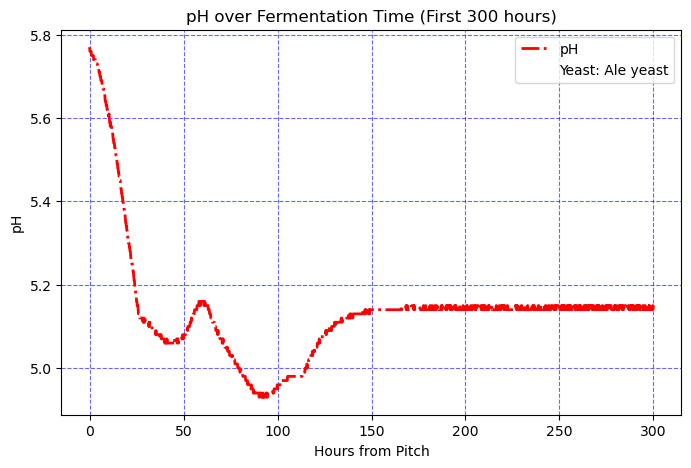

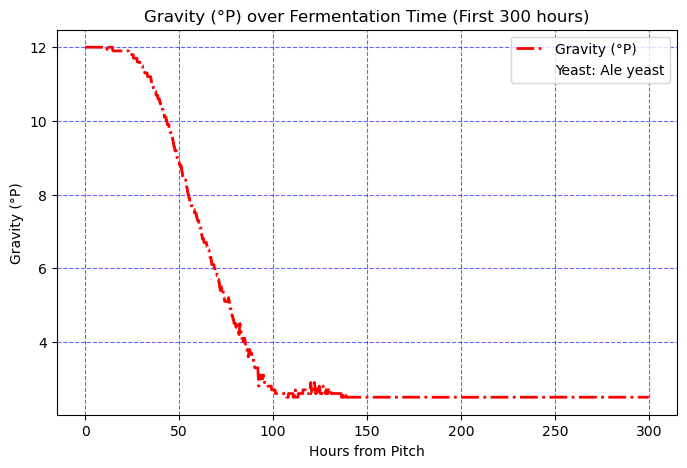

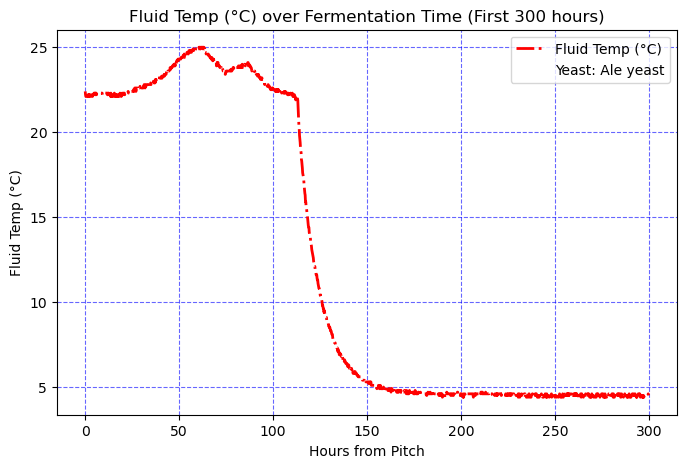

In [6]:
# Convert timestamp column to datetime
df["Timestamp (BST)"] = pd.to_datetime(df["Timestamp (BST)"])

# Filter data: only keep up to 300 hours from pitch
df_cut = df[df["Hours from Pitch"] <= 300]

# Define fermentation variables
variables = ["DO (mg/L)", "pH", "Gravity (°P)", "Fluid Temp (°C)"]

# Yeast type
yeast_type = "Ale yeast"

# Plot each variable
for var in variables:
    plt.figure(figsize=(8, 5))
    
    # Plot main variable line (use df_cut)
    plt.plot(df_cut["Hours from Pitch"], df_cut[var],
             label=var, linewidth=2, color="red", linestyle="-.")
    
    # Add yeast type as legend info
    plt.plot([], [], ' ', label=f"Yeast: {yeast_type}")
    
    plt.xlabel("Hours from Pitch")
    plt.ylabel(var)
    plt.title(f"{var} over Fermentation Time (First 300 hours)")
    plt.grid(True, linestyle="--", color="blue", alpha=0.6)
    plt.legend()
    plt.show()


In [7]:
# Information about the beer fermentation dataset
df_info = {
    "shape": df.shape,  # Number of rows and columns
    "columns": list(df.columns),  # List of column names
    "dtypes": df.dtypes.apply(lambda x: str(x)).to_dict(),  # Data types for each column
    "head": df.head(8).applymap(lambda x: str(x) if isinstance(x, pd.Timestamp) else x).to_dict(orient="list"),  # Preview first 8 rows
    "nan_counts": df.isna().sum().to_dict()  # Count missing values in each column
}

# Print the information in JSON format for readability
print(json.dumps(df_info, indent=2))

{
  "shape": [
    9933,
    9
  ],
  "columns": [
    "Timestamp (BST)",
    "Hours from Pitch",
    "DO (mg/L)",
    "pH",
    "Gravity (\u00b0P)",
    "Pressure (Bar)",
    "Fluid Temp (\u00b0C)",
    "Ambient Temp (\u00b0C)",
    "Conductivity (uS/cm)"
  ],
  "dtypes": {
    "Timestamp (BST)": "datetime64[ns]",
    "Hours from Pitch": "float64",
    "DO (mg/L)": "float64",
    "pH": "float64",
    "Gravity (\u00b0P)": "float64",
    "Pressure (Bar)": "float64",
    "Fluid Temp (\u00b0C)": "float64",
    "Ambient Temp (\u00b0C)": "float64",
    "Conductivity (uS/cm)": "float64"
  },
  "head": {
    "Timestamp (BST)": [
      "2022-06-17 16:00:00",
      "2022-06-17 16:10:00",
      "2022-06-17 16:20:00",
      "2022-06-17 16:30:00",
      "2022-06-17 16:40:00",
      "2022-06-17 16:50:00",
      "2022-06-17 17:00:00",
      "2022-06-17 17:10:00"
    ],
    "Hours from Pitch": [
      0.01,
      0.18,
      0.35,
      0.52,
      0.68,
      0.85,
      1.02,
      1.18
    ],
    

/var/folders/7q/1pqndbz17fbd8s_b61735x400000gn/T/ipykernel_5740/1581093731.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  "head": df.head(8).applymap(lambda x: str(x) if isinstance(x, pd.Timestamp) else x).to_dict(orient="list"),  # Preview first 8 rows


In [8]:
# Hyperparameters |PINN Settings
# Neural network architecture
#layers = [2, 64, 64, 64, 3]   
layers = [2, 128, 128, 128, 3]

# input: [t_scaled, T_scaled]  -> time and scaled temperature
# outputs: [X, Cs, Ce]          -> biomass, substrate, ethanol

# PINN collocation and training settings
N_f = 3000 #2000                  # number of collocation points for enforcing ODEs
lr = 5e-4   # 1e-3                   # learning rate
adam_epochs = 5000 #2000             # number of training epochs with Adam optimizer

# Physics-informed modelling
use_full_haldane = True        # use full Haldane kinetics for substrate inhibition
Y_e_s_fixed = 0.51             # ethanol yield (fixed)

# Temperature-dependent kinetics (Arrhenius-type)
mu_ref = 0.4                   # reference maximum growth rate [1/h]
K_s_ref = 0.1                  # reference substrate affinity [g/L]
K_i_ref = 50.0                  # reference inhibition constant [g/L]
T_ref = 30.0                    # reference temperature [°C]
Ea = 5000.0                     # activation energy [J/mol]
R = 8.314                        # gas constant [J/mol/K]

# Loss weights for PINN
w_data = 10 #1.0                    # weight for data loss
w_phys = 50 #100.0                   # weight for physics (ODE residual) loss
w_ic = 100.0                      # weight for initial condition loss

# Numerical stability
eps = 1e-8


In [9]:
# Columns in the CSV:
# 'Timestamp (BST)', 'Hours from Pitch', 'DO (mg/L)', 'pH', 
# 'Gravity (°P)', 'Pressure (Bar)', 'Fluid Temp (°C)', 'Ambient Temp (°C)', 'Conductivity (uS/cm)'

# We'll use:
# - 'Hours from Pitch' as time (t)
# - 'Gravity (°P)' as Plato (to compute substrate concentration)
# - 'Fluid Temp (°C)' as temperature input

t_data = df['Hours from Pitch'].to_numpy(dtype=float)
plato = df['Gravity (°P)'].to_numpy(dtype=float)
temp = df['Fluid Temp (°C)'].to_numpy(dtype=float)

In [10]:
# t_min = The starting time of fermentation 
# t_max = The final time of fermentation
t_min, t_max = float(np.min(t_data)), float(np.max(t_data))

print(f"Physical Time Range: {t_min:.2f} h to {t_max:.2f} h")
print(f"Total Fermentation Time: {t_max - t_min:.2f} h")

Physical Time Range: 0.01 h to 1655.47 h
Total Fermentation Time: 1655.46 h


In [11]:
# Scale | normalize inputs for PINN training
t_scaled = (t_data - t_data.min()) / (t_data.max() - t_data.min())
T_scaled = (temp - temp.min()) / (temp.max() - temp.min())

In [12]:
# Scaling Functions for Time and Temperature
def scale_time(t): return (t - t_min) / (t_max - t_min + 1e-12)
def unscale_time(ts): return ts * (t_max - t_min) + t_min
def scale_temp(T): 
    return (T - np.mean(temp)) / (np.max(temp)-np.min(temp)+1e-12)

t_scaled_all = scale_time(t_data).reshape(-1,1)
T_scaled_all = scale_temp(temp).reshape(-1,1)

In [13]:
# Plato to Sugar Concentration Conversion (g/L) 
def plato_to_concentration(P):
    """
    Convert Plato (°P) to sugar concentration (g/L) using an empirical density polynomial.
    Parameters:
        P (float or np.array): Plato value(s)
    Returns:
        Cs (float or np.array): Sugar concentration in g/L
    """
    # Density of wort in g/mL (empirical polynomial fit)
    rho = 1 + 0.003867 * P + 0.00001243 * P**2 + 0.000000013 * P**3
    
    # Convert to sugar concentration (g/L)
    Cs = (P / 100.0) * rho * 1000.0
    return Cs

# Apply conversion to your dataset
Cs_data = plato_to_concentration(plato)

# First 5 sugar concentrations
print("First 5 sugar concentrations (g/L):", Cs_data[:5])


First 5 sugar concentrations (g/L): [125.78596608 125.78596608 125.78596608 125.78596608 125.78596608]


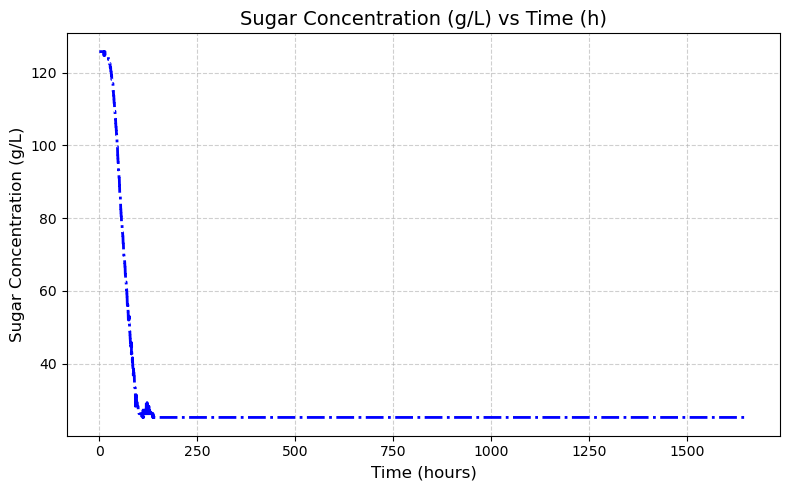

In [14]:
# Plot Sugar Concentration Over Time 
plt.figure(figsize=(8, 5))
plt.plot(t_data, Cs_data, linewidth=2, color="blue", linestyle="-.")

plt.xlabel("Time (hours)", fontsize=12)
plt.ylabel("Sugar Concentration (g/L)", fontsize=12)
plt.title("Sugar Concentration (g/L) vs Time (h)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

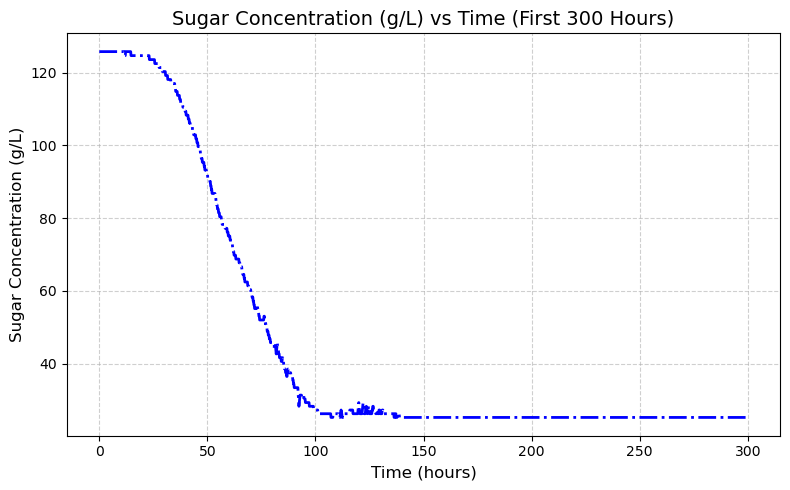

In [15]:
mask = t_data <= 300  # keep only time points ≤ 300 hours
t_data_cut = t_data[mask]
Cs_data_cut = Cs_data[mask]

# Plot Sugar Concentration Over Time (first 300 h
# ours)
plt.figure(figsize=(8, 5))
plt.plot(t_data_cut, Cs_data_cut, linewidth=2, color="blue", linestyle="-.")

plt.xlabel("Time (hours)", fontsize=12)
plt.ylabel("Sugar Concentration (g/L)", fontsize=12)
plt.title("Sugar Concentration (g/L) vs Time (First 300 Hours)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [16]:
# Convert scaled data into PyTorch tensors for PINN training
# Create a tensor for scaled time values (t_scaled_all)
# These are the observation points where we have measured sugar concentrations (Cs).
t_Cs = torch.tensor(t_scaled_all, dtype=torch.float32, device=device, requires_grad=False)

# Create a tensor for observed sugar concentrations (Cs_data)
Cs_obs = torch.tensor(Cs_data.reshape(-1, 1), dtype=torch.float32, device=device)

# Create a tensor for scaled temperature input (T_scaled_all)
T_input = torch.tensor(T_scaled_all, dtype=torch.float32, device=device)

# Initial conditions (ICs) for the differential equations
# Initial biomass concentration (X0)
x0 = 0.1    

# Initial sugar concentration (Cs0)
cs0 = float(Cs_data[0])
# Initial ethanol concentration (Ce0)
# Assumed zero at the beginning of fermentation (no ethanol yet).
ce0 = 0.0

In [17]:
# PINN Model Definition
class PINN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        
        # Neural network architecture 
        # layers: input=2 (time, temp), output=3 (X, Cs, Ce)
        self.layers = nn.ModuleList()
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))

        # Trainable physical (kinetic) parameters 
        # Initialised with approximate physical values (before optimization)
        self.p_mu = nn.Parameter(torch.tensor(0.2))    # μ_ref: max specific growth rate (h^-1)
        self.p_ks = nn.Parameter(torch.tensor(10.0))   # Ks: substrate saturation constant (g/L)
        self.p_ki_s = nn.Parameter(torch.tensor(100.0))# Ki_s: substrate inhibition constant (g/L)
        self.p_ki_eth = nn.Parameter(torch.tensor(100.0)) # Ki_eth: ethanol inhibition constant (g/L)
        self.p_L = nn.Parameter(torch.tensor(1.0))     # L: lag phase constant (h)
        self.p_Y_xs = nn.Parameter(torch.tensor(0.1))  # Y_x/s: yield of biomass from substrate
        self.p_Q10 = nn.Parameter(torch.tensor(1.5))   # Q10: temperature dependence factor

    # Forward Pass
    def forward(self, t_scaled, T_scaled):
        """
        Inputs:
            t_scaled : scaled time (N×1)
            T_scaled : scaled temperature (N×1)
        Returns:
            X_hat, Cs_hat, Ce_hat : predicted biomass, sugar, and ethanol concentrations
        """
        # Concatenate time and temperature as network input
        x = torch.cat([t_scaled, T_scaled], dim=1)

        # Pass through hidden layers with tanh activation
        for layer in self.layers[:-1]:
            x = torch.tanh(layer(x))

        # Final output layer (no activation)
        out = self.layers[-1](x)

        # Ensure non-negative outputs (physical constraint)
        # softplus(x) = log(1 + exp(x)) ensures outputs > 0
        X_hat = F.softplus(out[:, 0:1]) + 1e-8   # Biomass (g/L)
        Cs_hat = F.softplus(out[:, 1:2]) + 1e-8  # Sugar (g/L)
        Ce_hat = F.softplus(out[:, 2:3]) + 1e-8  # Ethanol (g/L)
        
        return X_hat, Cs_hat, Ce_hat

    # Extract positive, physically meaningful kinetic parameters
    def phys_params(self):
        """
        Apply softplus to ensure all kinetic parameters remain positive.
        Returns physically interpretable kinetic parameters.
        """
        mu_ref  = F.softplus(self.p_mu)    + 1e-8
        ks      = F.softplus(self.p_ks)    + 1e-8
        ki_s    = F.softplus(self.p_ki_s)  + 1e-8
        ki_eth  = F.softplus(self.p_ki_eth)+ 1e-8
        L       = F.softplus(self.p_L)     + 1e-8
        Y_xs    = F.softplus(self.p_Y_xs)  + 1e-8
        Q10     = F.softplus(self.p_Q10)   + 1e-8

        return mu_ref, ks, ki_s, ki_eth, L, Y_xs, Q10

    # Define temperature-dependent specific growth rate μ(T, S, E) 
    def mu(self, t_phys, Cs, Ce, T_phys, use_full=True):
        """
        Computes the specific growth rate μ using a temperature-corrected Haldane model.
        Args:
            t_phys : real time (h)
            Cs, Ce : sugar and ethanol concentrations (g/L)
            T_phys : actual temperature (°C)
            use_full : whether to include inhibition and lag terms
        """
        mu_ref, ks, ki_s, ki_eth, L, Y_xs, Q10 = self.phys_params()

        # Reference temperature (mean of the dataset)
        T_ref = np.mean(temp)

        # Temperature correction using the Q10 relationship:
        # μ(T) = μ_ref × Q10^((T - T_ref)/10)
        temp_factor = Q10 ** ((T_phys - T_ref) / 10.0)

        if use_full:
            # Full Haldane kinetics with substrate + ethanol inhibition and lag phase
            denom = ks + Cs + (Cs**2) / (ki_s + 1e-12)
            ethanol_term = 1.0 / (1.0 + Ce / (ki_eth + 1e-12))
            lag = 1.0 - torch.exp(-t_phys / (L + 1e-12))  # Lag phase correction
            mu = mu_ref * temp_factor * (Cs / (denom + 1e-12)) * ethanol_term * lag
        else:
            # Simplified Monod kinetics (no inhibition or lag)
            mu = mu_ref * temp_factor * Cs / (ks + Cs + 1e-12)

        return mu


In [18]:
# Instantiate the PINN model
# → 2 input features: (time, temperature)
# → 3 output features: (biomass X, sugar Cs, ethanol Ce)
model = PINN(layers).to(device)
print(f"Model initialized on: {device}")

Model initialized on: cpu


In [19]:
# Collocation Points for Physics-Based Loss

# Generate collocation points (random time samples within the fermentation period)
# These points are where the physics (Haldane ODEs) must hold true.
# N_f defines how many collocation points we use for the physics-based loss.
t_phys_coll = np.random.uniform(t_min, t_max, size=(N_f, 1))

# Scale the collocation time points to [0, 1] using the same function as for the data
# 'requires_grad=True' is crucial because we'll need time derivatives (dX/dt, dCs/dt, dCe/dt)
# for the physics residual computation.
t_phys_coll_scaled = torch.tensor(
    scale_time(t_phys_coll),
    dtype=torch.float32,
    device=device,
    requires_grad=True
)

# Interpolate temperature values at these collocation time points
# The measured temperature data ('temp') is mapped to each random time using interpolation.
# This ensures that each collocation point has a corresponding realistic temperature value.
T_phys_coll = np.interp(t_phys_coll.flatten(), t_data, temp).reshape(-1, 1)

# Scale the interpolated temperatures using the same normalization as training data
# Temperature scaling helps maintain consistent input distributions across all samples.
T_phys_coll_scaled = torch.tensor(
    scale_temp(T_phys_coll),
    dtype=torch.float32,
    device=device,
    requires_grad=False
)


In [20]:
# Helper Function: Compute Time Derivative using Autodiff 
def d_dt(u, t_scaled):
    """
    Compute the physical time derivative du/dt_phys from the network output u(t_scaled).

    Parameters
    ----------
    u : torch.Tensor
        Network output (e.g., predicted X, Cs, Ce) with shape (N, 1).
    t_scaled : torch.Tensor
        Scaled time input (in [0, 1]) with requires_grad=True for autodiff.

    Returns
    -------
    torch.Tensor
        Time derivative du/dt_phys (in original time units).
    """
    # Compute derivative wrt scaled time variable (du/dt_scaled)
    du = grad(
        outputs=u,
        inputs=t_scaled,
        grad_outputs=torch.ones_like(u),
        create_graph=True,
        retain_graph=True
    )[0]

    # Apply chain rule to get du/dt_phys:
    # t_scaled = (t_phys - t_min) / (t_max - t_min)
    # => dt_scaled/dt_phys = 1 / (t_max - t_min)
    scale_factor = 1.0 / (t_max - t_min + 1e-12)  # add small term for numerical stability

    # Convert back to derivative wrt physical time
    return du * scale_factor


In [21]:
# Loss Function
def loss_fn():
    """
    Compute total PINN loss:
    - data_loss: MSE between predicted and observed sugar (Cs)
    - ic_loss: initial condition loss for X, Cs, Ce
    - phys_loss: residuals of fermentation ODEs (Haldane model)
    """
    
    # 1️⃣ Data Loss (observed sugar Cs)
    X_pred_all, Cs_pred_all, Ce_pred_all = model(t_Cs, T_input)
    data_loss = F.mse_loss(Cs_pred_all, Cs_obs)

    # 2️⃣ Initial Condition (IC) Loss
    t0_scaled = torch.tensor([[scale_time(t_min)]], dtype=torch.float32, device=device)
    T0_scaled = torch.tensor([[scale_temp(temp[0])]], dtype=torch.float32, device=device)
    
    X0_pred, Cs0_pred, Ce0_pred = model(t0_scaled, T0_scaled)
    ic_loss = 0.0
    if cs0 is not None:
        ic_loss += F.mse_loss(Cs0_pred, torch.tensor([[cs0]], dtype=torch.float32, device=device))
    if x0 is not None:
        ic_loss += F.mse_loss(X0_pred, torch.tensor([[x0]], dtype=torch.float32, device=device))
    if ce0 is not None:
        ic_loss += F.mse_loss(Ce0_pred, torch.tensor([[ce0]], dtype=torch.float32, device=device))

    # 3️⃣ Physics Residual Loss
    t_phys_scaled = t_phys_coll_scaled  # (N_f,1)
    T_phys_scaled = T_phys_coll_scaled  # (N_f,1)
    
    # Physical time for μ computation (hours)
    t_phys_for_mu = torch.tensor(
        unscale_time(t_phys_scaled.detach().cpu().numpy()),
        dtype=torch.float32,
        device=device
    ).reshape(-1,1)

    # Ensure gradient can be computed w.r.t time
    t_phys_scaled.requires_grad = True
    
    # Forward pass at collocation points
    Xc, Csc, Cec = model(t_phys_scaled, T_phys_scaled)
    
    # Time derivatives using autodiff
    dXdt = d_dt(Xc, t_phys_scaled)
    dCsdt = d_dt(Csc, t_phys_scaled)
    dCedt = d_dt(Cec, t_phys_scaled)
    
    # Interpolated physical temperature for μ
    T_phys_for_mu = torch.tensor(
        np.interp(
            t_phys_for_mu.detach().cpu().numpy().flatten(),  # 1D
            t_data,
            temp
        ).reshape(-1,1),  # 2D
        dtype=torch.float32,
        device=device
    )

    # Compute μ (Haldane growth rate) at collocation points
    mu_pred = model.mu(
        t_phys_for_mu,  # hours
        Csc,
        Cec,
        T_phys_for_mu,
        use_full=use_full_haldane
    )

    # Physical parameters
    _, _, _, _, _, Y_xs, _ = model.phys_params()

    # Residuals of the fermentation ODEs
    rX  = dXdt - mu_pred * Xc
    rCs = dCsdt + (1.0 / (Y_xs + 1e-12)) * mu_pred * Xc
    rCe = dCedt - (Y_e_s_fixed / (Y_xs + 1e-12)) * mu_pred * Xc

    # Mean squared residuals
    phys_loss = (rX.pow(2).mean() + rCs.pow(2).mean() + rCe.pow(2).mean())

    # Total weighted loss
    total = w_data * data_loss + w_phys * phys_loss + w_ic * ic_loss

    return total, data_loss.detach(), phys_loss.detach(), ic_loss if isinstance(ic_loss, torch.Tensor) else torch.tensor(ic_loss)


In [22]:
# Training Loop (Adam Optimizer)

# Initialize the Adam optimizer with the model's parameters and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1500, gamma=0.7)
# Record start time for training duration
start = time.time()
print("Starting Adam training...")

# Loop over epochs for gradient-based optimization
for ep in range(1, adam_epochs + 1):
    
    # Zero the gradients from the previous step
    optimizer.zero_grad()
    
    # Compute total loss and individual components
    total_loss, dl, pl, il = loss_fn()
    
    # Backpropagate through the network to compute gradients
    total_loss.backward(retain_graph=True)
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # prevent exploding gradients
    # Update model parameters using Adam optimizer
    optimizer.step()
    
    # Print progress every 200 epochs and for the first epoch
    if ep % 250 == 0 or ep == 1: #200
        # Extract physical parameters for logging
        mu_ref, ks, ki_s, ki_eth, L, Y_xs, Q10 = model.phys_params()
        
        # Print epoch number, total loss, and individual losses
        print(f"Epoch {ep}/{adam_epochs}  total={total_loss.item():.6f} "
              f"data={dl.item():.6f} phys={pl.item():.6f} ic={il.item():.6f}")
        
        # Print current estimated physical parameters
        print(f"  params: mu_ref={float(mu_ref):.4f}, ks={float(ks):.3f}, "
              f"ki_s={float(ki_s):.1f}, ki_eth={float(ki_eth):.1f}, "
              f"L={float(L):.3f}, Y_xs={float(Y_xs):.4f}, Q10={float(Q10):.3f}")

# Record end time and print total training duration
end = time.time()
print("Adam training done in %.1f s" % (end - start))


Starting Adam training...
Epoch 1/5000  total=1575696.750000 data=1085.605347 phys=0.005525 ic=15648.404297
  params: mu_ref=0.7979, ks=10.001, ki_s=100.0, ki_eth=100.0, L=1.313, Y_xs=0.7447, Q10=1.701
Epoch 250/5000  total=1085754.125000 data=339.159760 phys=0.005899 ic=10823.622070
  params: mu_ref=0.7706, ks=10.039, ki_s=100.0, ki_eth=100.0, L=1.336, Y_xs=0.7710, Q10=1.664
Epoch 500/5000  total=772914.375000 data=369.446930 phys=0.004097 ic=7692.196777
  params: mu_ref=0.7562, ks=10.047, ki_s=99.9, ki_eth=100.0, L=1.344, Y_xs=0.7850, Q10=1.645
Epoch 750/5000  total=520279.718750 data=927.980652 phys=0.003613 ic=5109.997070
  params: mu_ref=0.7368, ks=10.054, ki_s=99.9, ki_eth=100.0, L=1.353, Y_xs=0.8038, Q10=1.621
Epoch 1000/5000  total=325910.343750 data=2007.374390 phys=0.003145 ic=3058.364502
  params: mu_ref=0.7098, ks=10.060, ki_s=99.8, ki_eth=100.0, L=1.364, Y_xs=0.8302, Q10=1.588
Epoch 1250/5000  total=154789.031250 data=137.885284 phys=0.005408 ic=1534.099121
  params: mu_re

In [23]:
# L-BFGS Refinement
print("Running short L-BFGS refinement...")

# Initialize the L-BFGS optimizer
optimizerLBFGS = torch.optim.LBFGS(
    model.parameters(),
    max_iter= 150, #100,         # number of optimization iterations
    history_size= 30, #20,      # memory for approximate Hessian
    line_search_fn='strong_wolfe'  # robust line search
)

# Define the closure function required by L-BFGS
def closure():
    optimizerLBFGS.zero_grad()      # reset gradients
    total_loss, dl, pl, il = loss_fn()  # compute total loss
    total_loss.backward()           # compute gradients
    return total_loss               # return loss for optimizer

# Run the L-BFGS optimizer
optimizerLBFGS.step(closure)

print("L-BFGS done.")


Running short L-BFGS refinement...
L-BFGS done.


In [24]:
# Evaluate and Plot
model.eval()  

with torch.no_grad():  
    t_plot = np.linspace(t_min, t_max, 500).reshape(-1,1)
    t_plot_scaled = torch.tensor(scale_time(t_plot), dtype=torch.float32, device=device)
    
    # Interpolate temperature at these time points (physical °C)
    T_plot = np.interp(t_plot.flatten(), t_data, temp).reshape(-1,1)
    
    # Scale temperature to match PINN input scaling
    T_plot_scaled = torch.tensor(scale_temp(T_plot), dtype=torch.float32, device=device)
    
    # Forward pass through the PINN to get predictions
    Xp, Csp, Cep = model(t_plot_scaled, T_plot_scaled)
    
    # Convert predictions to NumPy arrays and flatten for plotting
    Xp = Xp.cpu().numpy().flatten()   # biomass (g/L)
    Csp = Csp.cpu().numpy().flatten() # sugar concentration (g/L)
    Cep = Cep.cpu().numpy().flatten() # ethanol concentration (g/L)


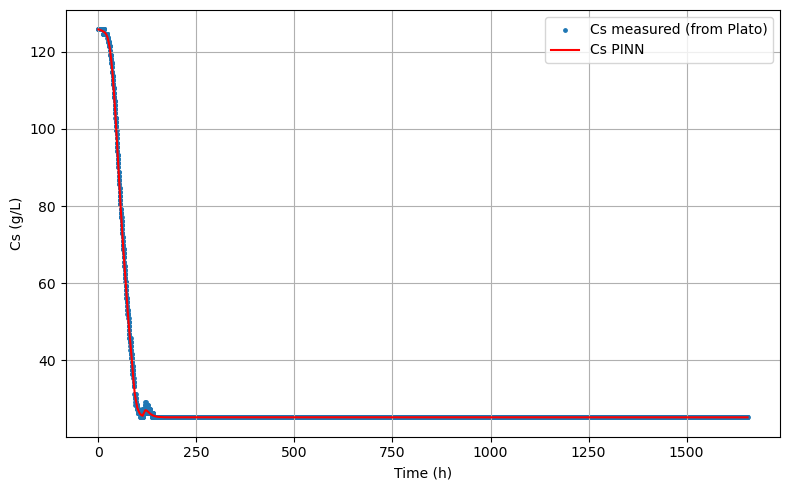

In [25]:
# Plot Cs (measured vs predicted)
plt.figure(figsize=(8,5))
plt.scatter(t_data, Cs_data, s=6, label="Cs measured (from Plato)")
plt.plot(t_plot, Csp, color='red', label="Cs PINN")

plt.xlabel("Time (h)")
plt.ylabel("Cs (g/L)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

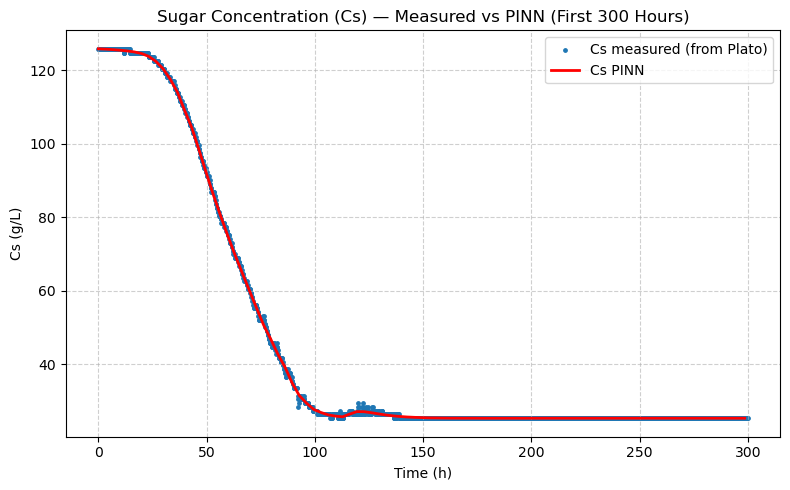

In [26]:
# --- Ensure 1D arrays ---
t_data_flat = np.ravel(t_data)
Cs_data_flat = np.ravel(Cs_data)
t_plot_flat = np.ravel(t_plot)
Csp_flat = np.ravel(Csp)

# --- Filter to time ≤ 300 hours ---
mask_data = t_data_flat <= 300
mask_plot = t_plot_flat <= 300

t_data_cut = t_data_flat[mask_data]
Cs_data_cut = Cs_data_flat[mask_data]
t_plot_cut = t_plot_flat[mask_plot]
Csp_cut = Csp_flat[mask_plot]

# --- Plot measured vs PINN-predicted Cs ---
plt.figure(figsize=(8, 5))
plt.scatter(t_data_cut, Cs_data_cut, s=6, label="Cs measured (from Plato)")
plt.plot(t_plot_cut, Csp_cut, color='red', linewidth=2, label="Cs PINN")

plt.xlabel("Time (h)")
plt.ylabel("Cs (g/L)")
plt.title("Sugar Concentration (Cs) — Measured vs PINN (First 300 Hours)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


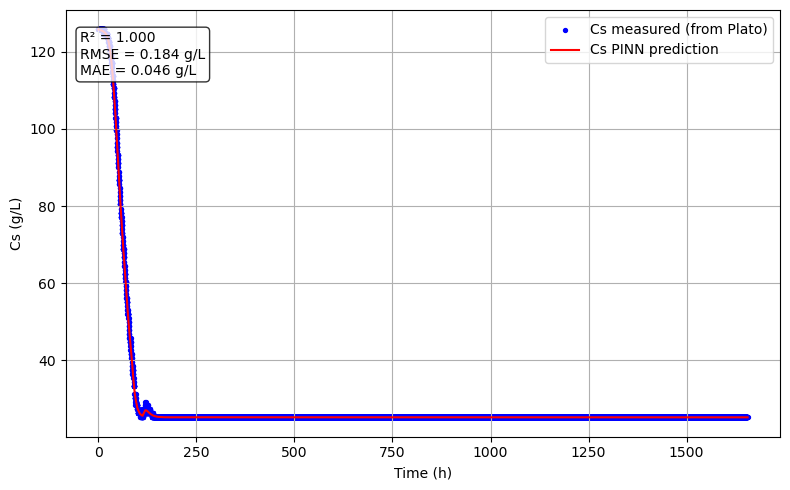

In [27]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# --- Interpolate predicted values to measurement times for fair comparison ---
Cs_pred_interp = np.interp(t_data, t_plot.flatten(), Csp)

# --- Compute metrics ---
r2 = r2_score(Cs_data, Cs_pred_interp)
rmse = np.sqrt(mean_squared_error(Cs_data, Cs_pred_interp))
mae = mean_absolute_error(Cs_data, Cs_pred_interp)

# --- Plot measured vs predicted ---
plt.figure(figsize=(8,5))
plt.scatter(t_data, Cs_data, s=8, label="Cs measured (from Plato)", color='blue')
plt.plot(t_plot, Csp, color='red', label="Cs PINN prediction")

# --- Add text with accuracy metrics ---
textstr = f"R² = {r2:.3f}\nRMSE = {rmse:.3f} g/L\nMAE = {mae:.3f} g/L"
plt.text(0.02, 0.95, textstr, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.xlabel("Time (h)")
plt.ylabel("Cs (g/L)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


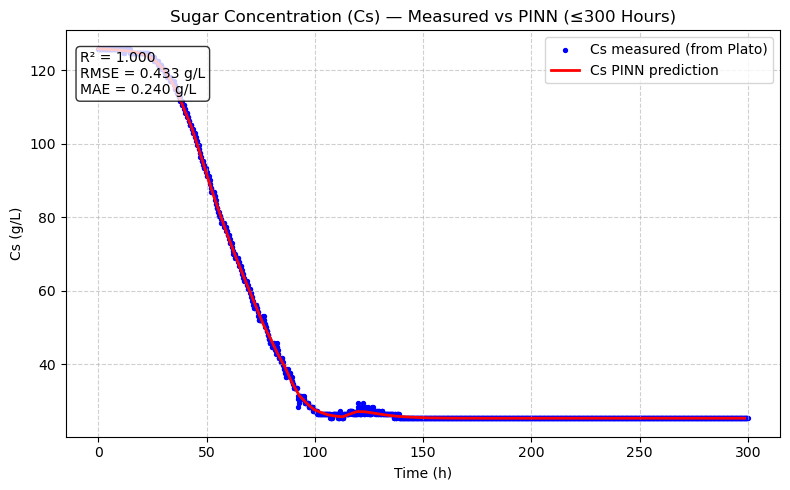

In [28]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
# --- Flatten arrays to 1D for consistency ---
t_data_flat = np.ravel(t_data)
Cs_data_flat = np.ravel(Cs_data)
t_plot_flat = np.ravel(t_plot)
Csp_flat = np.ravel(Csp)

# --- Filter to first 300 hours ---
mask_data = t_data_flat <= 300
mask_plot = t_plot_flat <= 300

t_data_cut = t_data_flat[mask_data]
Cs_data_cut = Cs_data_flat[mask_data]
t_plot_cut = t_plot_flat[mask_plot]
Csp_cut = Csp_flat[mask_plot]

# --- Interpolate predicted values to measurement times (for fair comparison) ---
Cs_pred_interp = np.interp(t_data_cut, t_plot_cut, Csp_cut)

# --- Compute evaluation metrics ---
r2 = r2_score(Cs_data_cut, Cs_pred_interp)
rmse = np.sqrt(mean_squared_error(Cs_data_cut, Cs_pred_interp))
mae = mean_absolute_error(Cs_data_cut, Cs_pred_interp)

# --- Plot measured vs predicted ---
plt.figure(figsize=(8, 5))
plt.scatter(t_data_cut, Cs_data_cut, s=8, label="Cs measured (from Plato)", color='blue')
plt.plot(t_plot_cut, Csp_cut, color='red', linewidth=2, label="Cs PINN prediction")

# --- Add performance metrics text box ---
textstr = f"R² = {r2:.3f}\nRMSE = {rmse:.3f} g/L\nMAE = {mae:.3f} g/L"
plt.text(0.02, 0.95, textstr, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.xlabel("Time (h)")
plt.ylabel("Cs (g/L)")
plt.title("Sugar Concentration (Cs) — Measured vs PINN (≤300 Hours)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


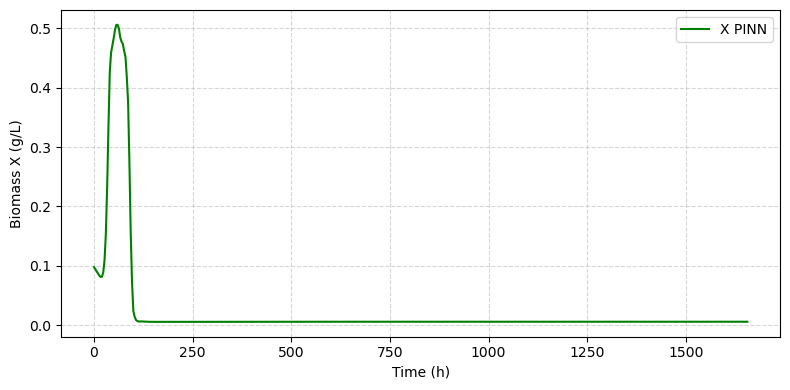

In [29]:
# Plot X Biomass(predicted)
plt.figure(figsize=(8,4))

plt.plot(t_plot, Xp, color='green', label="X PINN")

plt.xlabel("Time (h)")
plt.ylabel("Biomass X (g/L)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


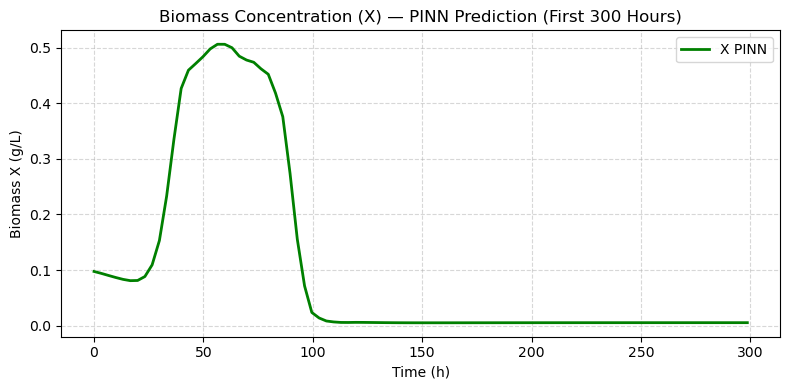

In [30]:
# --- Ensure arrays are 1D ---
t_plot_flat = np.ravel(t_plot)
Xp_flat = np.ravel(Xp)

# --- Filter to time ≤ 300 hours ---
mask_plot = t_plot_flat <= 300
t_plot_cut = t_plot_flat[mask_plot]
Xp_cut = Xp_flat[mask_plot]

# --- Plot X Biomass (PINN-predicted, ≤300 h) ---
plt.figure(figsize=(8, 4))
plt.plot(t_plot_cut, Xp_cut, color='green', linewidth=2, label="X PINN")

plt.xlabel("Time (h)")
plt.ylabel("Biomass X (g/L)")
plt.title("Biomass Concentration (X) — PINN Prediction (First 300 Hours)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


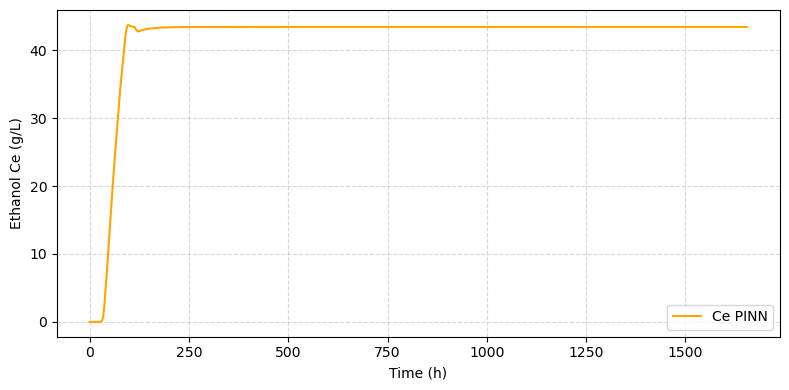

In [31]:
# Plot Ce (PINN-predicted ethanol)
plt.figure(figsize=(8,4))
plt.plot(t_plot, Cep, color='orange', label="Ce PINN")

plt.xlabel("Time (h)")
plt.ylabel("Ethanol Ce (g/L)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

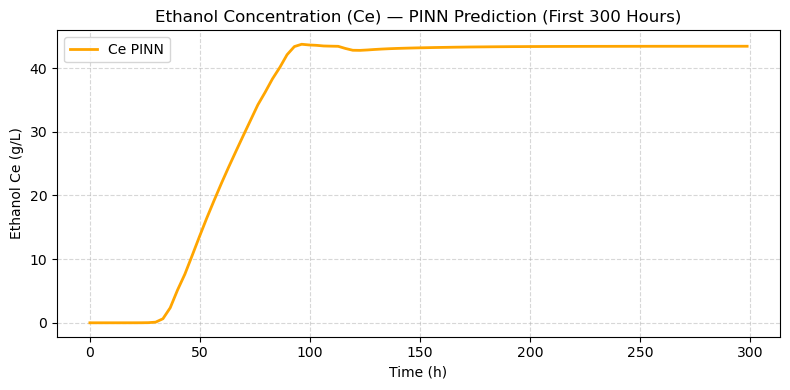

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# --- Ensure both arrays are 1D ---
t_plot_flat = np.ravel(t_plot)   # flattens to shape (N,)
Cep_flat = np.ravel(Cep)         # flattens to shape (N,)

# --- Filter to time ≤ 300 hours ---
mask_plot = t_plot_flat <= 300
t_plot_cut = t_plot_flat[mask_plot]
Cep_cut = Cep_flat[mask_plot]

# --- Plot Ce (PINN-predicted ethanol, ≤300h) ---
plt.figure(figsize=(8, 4))
plt.plot(t_plot_cut, Cep_cut, color='orange', linewidth=2, label="Ce PINN")

plt.xlabel("Time (h)")
plt.ylabel("Ethanol Ce (g/L)")
plt.title("Ethanol Concentration (Ce) — PINN Prediction (First 300 Hours)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [33]:
# Retrieve learned physical parameters from the model
mu_ref, ks, ki_s, ki_eth, L, Y_xs, Q10 = model.phys_params()

print("Learned parameters:")
# Maximum specific growth rate (h^-1)
print(f"mu_ref = {float(mu_ref):.5f} h^-1")
# Monod half-saturation constant for sugar (g/L)
print(f"ks = {float(ks):.5f} g/L")
# Haldane inhibition constant for sugar (g/L)
print(f"ki_sugar = {float(ki_s):.5f} g/L")
# Haldane inhibition constant for ethanol (g/L)
print(f"ki_eth = {float(ki_eth):.5f} g/L")
# Lag phase parameter (h)
print(f"L = {float(L):.5f} h")
# Biomass yield coefficient (g biomass / g sugar)
print(f"Y_x/s = {float(Y_xs):.5f} g/g")
# Temperature factor (Q10)
print(f"Q10 = {float(Q10):.5f} (temperature factor)")


Learned parameters:
mu_ref = 0.29839 h^-1
ks = 10.95534 g/L
ki_sugar = 99.52672 g/L
ki_eth = 99.43569 g/L
L = 2.93791 h
Y_x/s = 0.06295 g/g
Q10 = 1.22860 (temperature factor)


In [34]:
# Save results
Cs_measured_interp = np.interp(t_plot.flatten(), t_data, Cs_data)

out = pd.DataFrame({
    "time_h": t_plot.flatten(),                   # Time in hours (unscaled)
    "Cs_measured_gL": Cs_measured_interp,         # Measured sugar concentration (g/L)
    "Cs_pred_gL": Csp,                            # Predicted sugar concentration (g/L)
    "X_pred_gL": Xp,                              # Predicted biomass (g/L)
    "Ce_pred_gL": Cep                             # Predicted ethanol concentration (g/L)
})

out_path = "data/pinn_results_02_IPA_SA_05_full.csv"
out.to_csv(out_path, index=False)
print("Saved predictions (with measured Cs) to", out_path)

Saved predictions (with measured Cs) to data/pinn_results_02_IPA_SA_05_full.csv


In [44]:
# ============================================================
# Imports
# ============================================================
import os
import time
import math
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from torch.utils.data import TensorDataset, DataLoader

In [45]:
# ============================================================
# Device & seeds
# ============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

np.random.seed(42)
torch.manual_seed(42)

Device: cpu


In [49]:
# ============================================================
# Load dataset
# ============================================================
file_path = "data/02 - IPA - SA-05.csv" 
df = pd.read_csv(file_path)

print("First 5 rows:\n", df.head())
print("\nColumns:\n", df.columns)
print("\nDataset shape:", df.shape)

First 5 rows:
        Timestamp (BST)  Hours from Pitch  DO (mg/L)    pH  Gravity (°P)  \
0  2022-06-17 16:00:00              0.01       1.72  5.77          12.0   
1  2022-06-17 16:10:00              0.18       1.69  5.76          12.0   
2  2022-06-17 16:20:00              0.35       1.70  5.76          12.0   
3  2022-06-17 16:30:00              0.52       1.60  5.76          12.0   
4  2022-06-17 16:40:00              0.68       1.54  5.76          12.0   

   Pressure (Bar)  Fluid Temp (°C)  Ambient Temp (°C)  Conductivity (uS/cm)  
0            0.07             22.4               20.0                2418.0  
1            0.07             22.2               20.0                2424.0  
2            0.07             22.1               20.0                2427.0  
3            0.07             22.1               19.0                2424.0  
4            0.07             22.1               19.0                2427.0  

Columns:
 Index(['Timestamp (BST)', 'Hours from Pitch', 'DO (mg/L

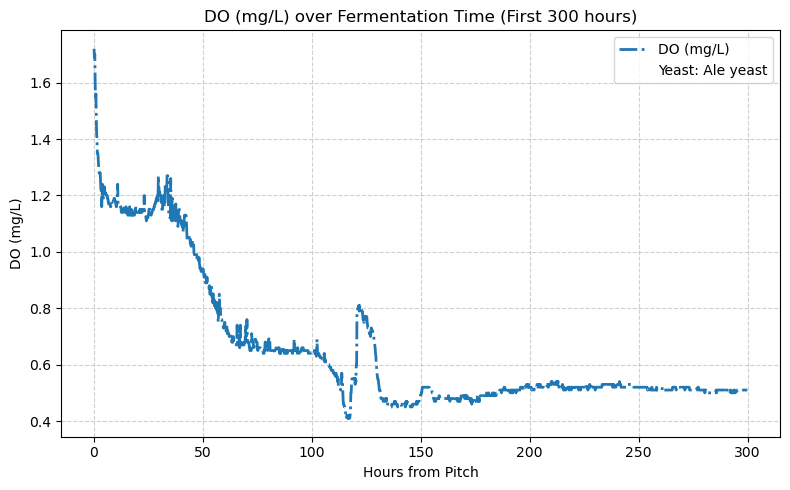

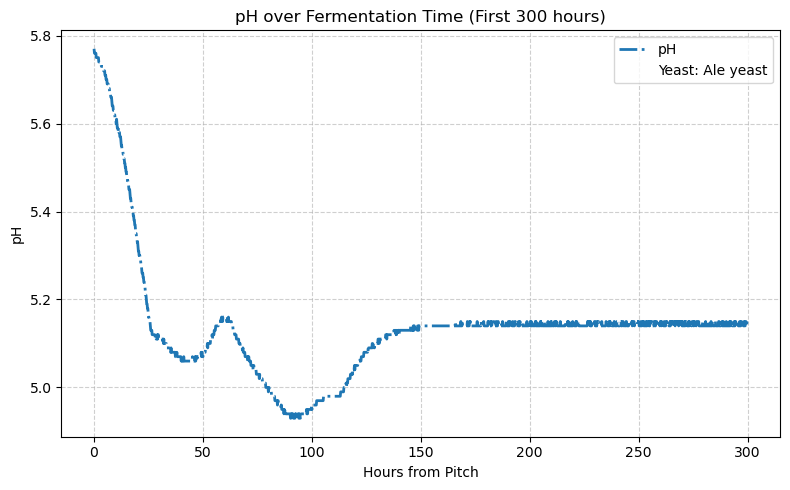

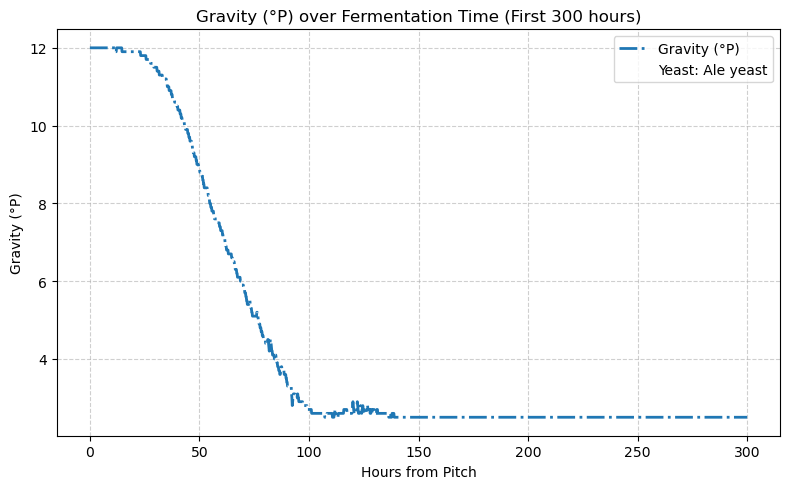

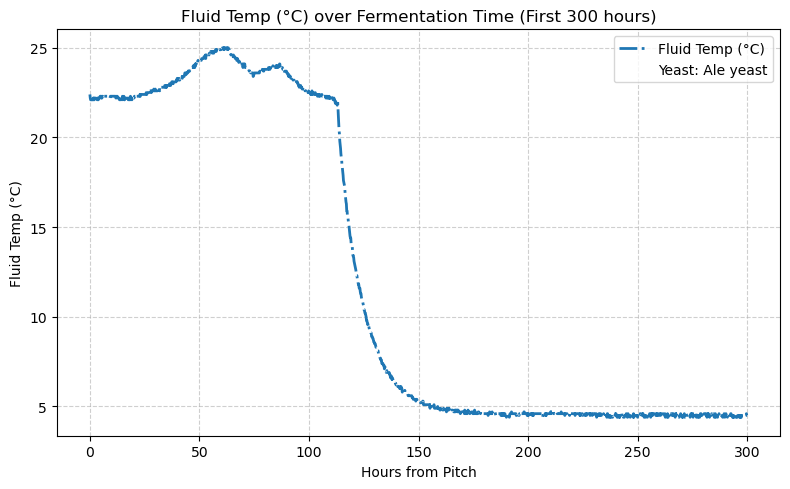

In [51]:
# ============================================================
# Basic preprocessing & plots with correct column names
# ============================================================
# Column mapping for THIS dataset:
# time        -> "Hours from Pitch"
# sugar (°P)  -> "Gravity (°P)"
# temperature -> "Fluid Temp (°C)"
# pH          -> "pH"
# DO          -> "DO (mg/L)"

# Convert timestamp once (optional but useful)
df["Timestamp (BST)"] = pd.to_datetime(df["Timestamp (BST)"])

yeast_type = "Ale yeast"  # or any label you like

variables = {
    "DO (mg/L)": "DO (mg/L)",
    "pH": "pH",
    "Gravity (°P)": "Gravity (°P)",
    "Fluid Temp (°C)": "Fluid Temp (°C)",
}

# Limit to ≤ 300 h for descriptive plots
df_cut = df[df["Hours from Pitch"] <= 300]

for col, label in variables.items():
    plt.figure(figsize=(8, 5))
    plt.plot(df_cut["Hours from Pitch"], df_cut[col],
             label=label, linewidth=2, linestyle="-.")
    plt.plot([], [], " ", label=f"Yeast: {yeast_type}")
    plt.xlabel("Hours from Pitch")
    plt.ylabel(label)
    plt.title(f"{label} over Fermentation Time (First 300 hours)")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Dataset info
df_info = {
    "shape": df.shape,
    "columns": list(df.columns),
    "dtypes": df.dtypes.apply(lambda x: str(x)).to_dict(),
    "head": df.head(8).to_dict(orient="list"),
    "nan_counts": df.isna().sum().to_dict()
}


In [54]:
# ============================================================
# Extract basic time / Plato / temperature  (correct column names)
# ============================================================
t_data = df["Hours from Pitch"].to_numpy(dtype=float)       # time
plato  = df["Gravity (°P)"].to_numpy(dtype=float)           # °P → sugar
temp   = df["Fluid Temp (°C)"].to_numpy(dtype=float)        # temperature

t_min, t_max = float(np.min(t_data)), float(np.max(t_data))
print(f"Physical Time Range: {t_min:.2f} h to {t_max:.2f} h")
print(f"Total Fermentation Time: {t_max - t_min:.2f} h")

Physical Time Range: 0.01 h to 1655.47 h
Total Fermentation Time: 1655.46 h


In [55]:
# ============================================================
# Scaling functions for PINN
# ============================================================
def scale_time(t):
    return (t - t_min) / (t_max - t_min + 1e-12)

def unscale_time(ts):
    return ts * (t_max - t_min) + t_min

def scale_temp(T):
    return (T - np.mean(temp)) / (np.max(temp) - np.min(temp) + 1e-12)

t_scaled_all = scale_time(t_data).reshape(-1, 1)
T_scaled_all = scale_temp(temp).reshape(-1, 1)

First 5 sugar concentrations (g/L): [125.78596608 125.78596608 125.78596608 125.78596608 125.78596608]


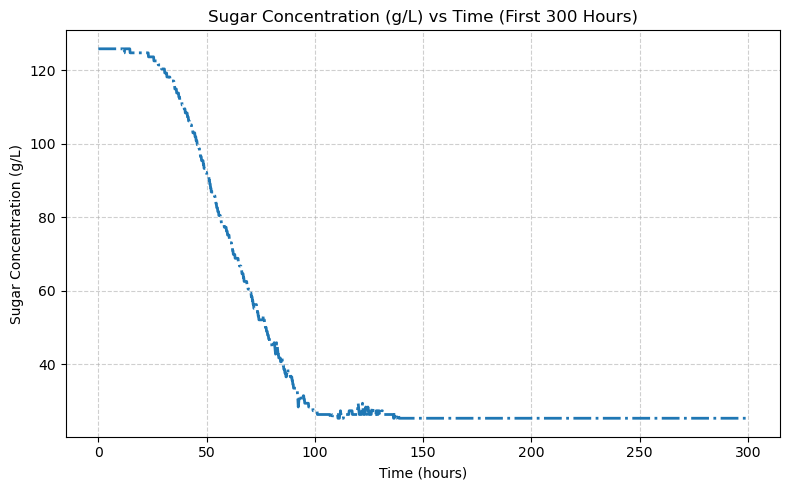

In [58]:
# ============================================================
# Plato → Sugar concentration Cs (g/L)
# ============================================================
def plato_to_concentration(P):
    rho = 1 + 0.003867 * P + 0.00001243 * P**2 + 0.000000013 * P**3
    Cs = (P / 100.0) * rho * 1000.0
    return Cs

Cs_data = plato_to_concentration(plato)
print("First 5 sugar concentrations (g/L):", Cs_data[:5])

# Sugar vs time (≤300 h)
mask_300_data = t_data <= 300
plt.figure(figsize=(8, 5))
plt.plot(t_data[mask_300_data], Cs_data[mask_300_data],
         linewidth=2, linestyle="-.")
plt.xlabel("Time (hours)")
plt.ylabel("Sugar Concentration (g/L)")
plt.title("Sugar Concentration (g/L) vs Time (First 300 Hours)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [59]:
# ============================================================
# PINN setup
# ============================================================
layers = [2, 128, 128, 128, 3]   # [t_scaled, T_scaled] -> [X, Cs, Ce]
N_f = 3000
lr = 5e-4
adam_epochs = 5000

use_full_haldane = True
Y_e_s_fixed = 0.51

w_data = 10
w_phys = 50
w_ic   = 100.0
eps = 1e-8

# PINN tensors
t_Cs    = torch.tensor(t_scaled_all, dtype=torch.float32, device=device, requires_grad=False)
Cs_obs  = torch.tensor(Cs_data.reshape(-1, 1), dtype=torch.float32, device=device)
T_input = torch.tensor(T_scaled_all, dtype=torch.float32, device=device)

# Initial conditions
x0  = 0.1
cs0 = float(Cs_data[0])
ce0 = 0.0

In [60]:
# ============================================================
# PINN model definition
# ============================================================
class PINN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))

        self.p_mu     = nn.Parameter(torch.tensor(0.2))
        self.p_ks     = nn.Parameter(torch.tensor(10.0))
        self.p_ki_s   = nn.Parameter(torch.tensor(100.0))
        self.p_ki_eth = nn.Parameter(torch.tensor(100.0))
        self.p_L      = nn.Parameter(torch.tensor(1.0))
        self.p_Y_xs   = nn.Parameter(torch.tensor(0.1))
        self.p_Q10    = nn.Parameter(torch.tensor(1.5))

    def forward(self, t_scaled, T_scaled):
        x = torch.cat([t_scaled, T_scaled], dim=1)
        for layer in self.layers[:-1]:
            x = torch.tanh(layer(x))
        out = self.layers[-1](x)
        X_hat  = F.softplus(out[:, 0:1]) + 1e-8
        Cs_hat = F.softplus(out[:, 1:2]) + 1e-8
        Ce_hat = F.softplus(out[:, 2:3]) + 1e-8
        return X_hat, Cs_hat, Ce_hat

    def phys_params(self):
        mu_ref  = F.softplus(self.p_mu)     + 1e-8
        ks      = F.softplus(self.p_ks)     + 1e-8
        ki_s    = F.softplus(self.p_ki_s)   + 1e-8
        ki_eth  = F.softplus(self.p_ki_eth) + 1e-8
        L       = F.softplus(self.p_L)      + 1e-8
        Y_xs    = F.softplus(self.p_Y_xs)   + 1e-8
        Q10     = F.softplus(self.p_Q10)    + 1e-8
        return mu_ref, ks, ki_s, ki_eth, L, Y_xs, Q10

    def mu(self, t_phys, Cs, Ce, T_phys, use_full=True):
        mu_ref, ks, ki_s, ki_eth, L, Y_xs, Q10 = self.phys_params()
        T_ref_loc = np.mean(temp)
        temp_factor = Q10 ** ((T_phys - T_ref_loc) / 10.0)
        if use_full:
            denom = ks + Cs + (Cs**2) / (ki_s + 1e-12)
            ethanol_term = 1.0 / (1.0 + Ce / (ki_eth + 1e-12))
            lag = 1.0 - torch.exp(-t_phys / (L + 1e-12))
            mu = mu_ref * temp_factor * (Cs / (denom + 1e-12)) * ethanol_term * lag
        else:
            mu = mu_ref * temp_factor * Cs / (ks + Cs + 1e-12)
        return mu

model = PINN(layers).to(device)
print(f"PINN model on: {device}")

PINN model on: cpu


In [61]:
# ============================================================
# Collocation points for physics loss
# ============================================================
t_phys_coll = np.random.uniform(t_min, t_max, size=(N_f, 1))
t_phys_coll_scaled = torch.tensor(
    scale_time(t_phys_coll),
    dtype=torch.float32,
    device=device,
    requires_grad=True
)
T_phys_coll = np.interp(t_phys_coll.flatten(), t_data, temp).reshape(-1, 1)
T_phys_coll_scaled = torch.tensor(
    scale_temp(T_phys_coll),
    dtype=torch.float32,
    device=device,
    requires_grad=False
)

In [62]:
# ============================================================
# Helper for time derivative
# ============================================================
def d_dt(u, t_scaled):
    du = grad(
        outputs=u,
        inputs=t_scaled,
        grad_outputs=torch.ones_like(u),
        create_graph=True,
        retain_graph=True
    )[0]
    scale_factor = 1.0 / (t_max - t_min + 1e-12)
    return du * scale_factor

In [63]:
# ============================================================
# Loss function
# ============================================================
def loss_fn():
    X_pred_all, Cs_pred_all, Ce_pred_all = model(t_Cs, T_input)
    data_loss = F.mse_loss(Cs_pred_all, Cs_obs)

    t0_scaled = torch.tensor([[scale_time(t_min)]], dtype=torch.float32, device=device)
    T0_scaled = torch.tensor([[scale_temp(temp[0])]], dtype=torch.float32, device=device)
    X0_pred, Cs0_pred, Ce0_pred = model(t0_scaled, T0_scaled)

    ic_loss = 0.0
    if cs0 is not None:
        ic_loss += F.mse_loss(Cs0_pred, torch.tensor([[cs0]], dtype=torch.float32, device=device))
    if x0 is not None:
        ic_loss += F.mse_loss(X0_pred, torch.tensor([[x0]], dtype=torch.float32, device=device))
    if ce0 is not None:
        ic_loss += F.mse_loss(Ce0_pred, torch.tensor([[ce0]], dtype=torch.float32, device=device))

    t_phys_scaled = t_phys_coll_scaled
    T_phys_scaled = T_phys_coll_scaled

    t_phys_for_mu = torch.tensor(
        unscale_time(t_phys_scaled.detach().cpu().numpy()),
        dtype=torch.float32,
        device=device
    ).reshape(-1, 1)

    t_phys_scaled.requires_grad = True

    Xc, Csc, Cec = model(t_phys_scaled, T_phys_scaled)
    dXdt  = d_dt(Xc,  t_phys_scaled)
    dCsdt = d_dt(Csc, t_phys_scaled)
    dCedt = d_dt(Cec, t_phys_scaled)

    T_phys_for_mu = torch.tensor(
        np.interp(
            t_phys_for_mu.detach().cpu().numpy().flatten(),
            t_data,
            temp
        ).reshape(-1, 1),
        dtype=torch.float32,
        device=device
    )

    mu_pred = model.mu(
        t_phys_for_mu,
        Csc,
        Cec,
        T_phys_for_mu,
        use_full=use_full_haldane
    )

    _, _, _, _, _, Y_xs, _ = model.phys_params()

    rX  = dXdt  - mu_pred * Xc
    rCs = dCsdt + (1.0 / (Y_xs + 1e-12)) * mu_pred * Xc
    rCe = dCedt - (Y_e_s_fixed / (Y_xs + 1e-12)) * mu_pred * Xc

    phys_loss = rX.pow(2).mean() + rCs.pow(2).mean() + rCe.pow(2).mean()

    total = w_data * data_loss + w_phys * phys_loss + w_ic * ic_loss
    return total, data_loss.detach(), phys_loss.detach(), ic_loss if isinstance(ic_loss, torch.Tensor) else torch.tensor(ic_loss)


In [64]:
# ============================================================
# PINN training (Adam + LBFGS)
# ============================================================
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1500, gamma=0.7)

start = time.time()
print("Starting Adam training...")

for ep in range(1, adam_epochs + 1):
    optimizer.zero_grad()
    total_loss, dl, pl, il = loss_fn()
    total_loss.backward(retain_graph=True)
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    scheduler.step()

    if ep % 250 == 0 or ep == 1:
        mu_ref_t, ks_t, ki_s_t, ki_eth_t, L_t, Y_xs_t, Q10_t = model.phys_params()
        print(f"Epoch {ep}/{adam_epochs}  total={total_loss.item():.6f} "
              f"data={dl.item():.6f} phys={pl.item():.6f} ic={il.item():.6f}")
        print(f"  params: mu_ref={float(mu_ref_t):.4f}, ks={float(ks_t):.3f}, "
              f"ki_s={float(ki_s_t):.1f}, ki_eth={float(ki_eth_t):.1f}, "
              f"L={float(L_t):.3f}, Y_xs={float(Y_xs_t):.4f}, Q10={float(Q10_t):.3f}")

end = time.time()
print("Adam training done in %.1f s" % (end - start))

print("Running short L-BFGS refinement...")
optimizerLBFGS = torch.optim.LBFGS(
    model.parameters(),
    max_iter=150,
    history_size=30,
    line_search_fn="strong_wolfe",
)

def closure():
    optimizerLBFGS.zero_grad()
    total_loss, dl, pl, il = loss_fn()
    total_loss.backward()
    return total_loss

optimizerLBFGS.step(closure)
print("L-BFGS done.")


Starting Adam training...
Epoch 1/5000  total=1575696.750000 data=1085.605347 phys=0.005525 ic=15648.404297
  params: mu_ref=0.7979, ks=10.001, ki_s=100.0, ki_eth=100.0, L=1.313, Y_xs=0.7447, Q10=1.701
Epoch 250/5000  total=1085754.125000 data=339.159760 phys=0.005899 ic=10823.622070
  params: mu_ref=0.7706, ks=10.039, ki_s=100.0, ki_eth=100.0, L=1.336, Y_xs=0.7710, Q10=1.664
Epoch 500/5000  total=772914.375000 data=369.446930 phys=0.004097 ic=7692.196777
  params: mu_ref=0.7562, ks=10.047, ki_s=99.9, ki_eth=100.0, L=1.344, Y_xs=0.7850, Q10=1.645
Epoch 750/5000  total=520279.718750 data=927.980652 phys=0.003613 ic=5109.997070
  params: mu_ref=0.7368, ks=10.054, ki_s=99.9, ki_eth=100.0, L=1.353, Y_xs=0.8038, Q10=1.621
Epoch 1000/5000  total=325910.343750 data=2007.374390 phys=0.003145 ic=3058.364502
  params: mu_ref=0.7098, ks=10.060, ki_s=99.8, ki_eth=100.0, L=1.364, Y_xs=0.8302, Q10=1.588
Epoch 1250/5000  total=154789.031250 data=137.885284 phys=0.005408 ic=1534.099121
  params: mu_re

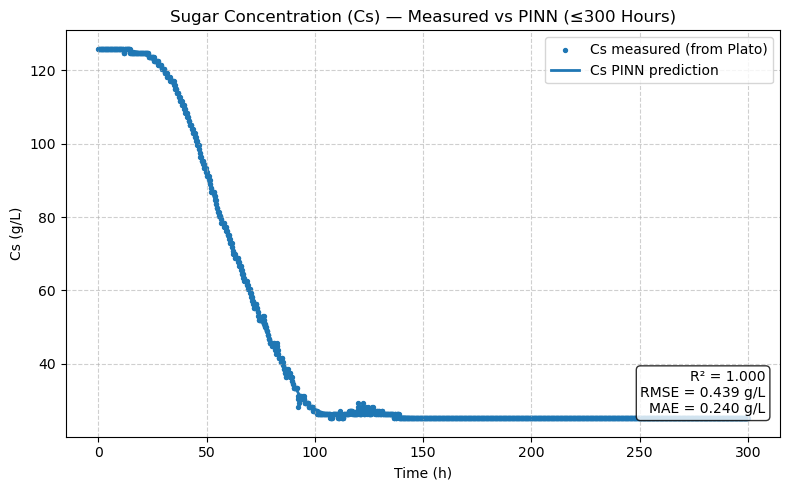

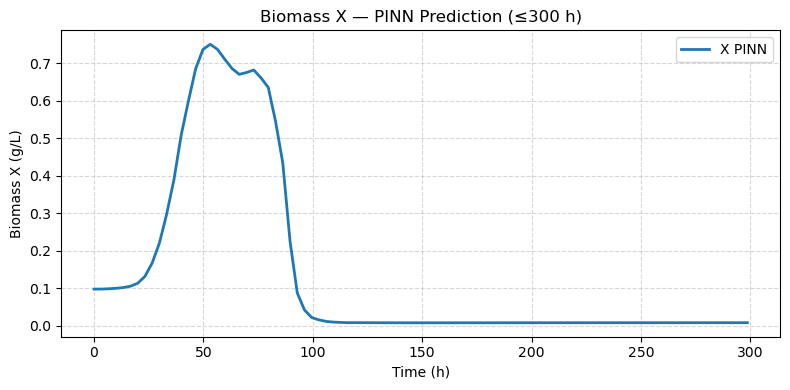

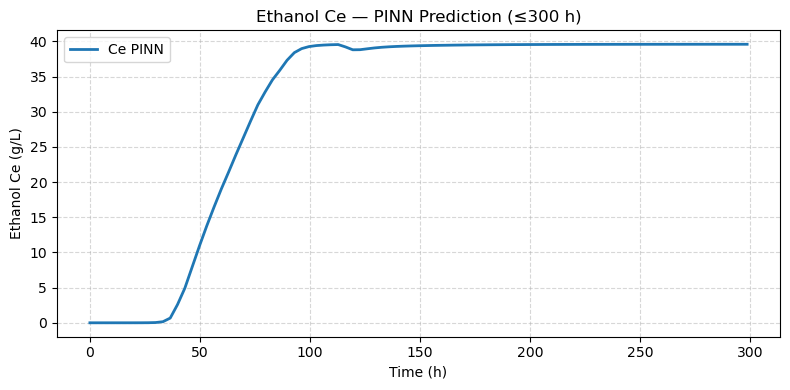

In [ ]:
# ============================================================
# PINN evaluation on dense grid
# ============================================================
model.eval()
with torch.no_grad():
    t_plot = np.linspace(t_min, t_max, 500).reshape(-1, 1)
    t_plot_scaled = torch.tensor(scale_time(t_plot), dtype=torch.float32, device=device)
    T_plot = np.interp(t_plot.flatten(), t_data, temp).reshape(-1, 1)
    T_plot_scaled = torch.tensor(scale_temp(T_plot), dtype=torch.float32, device=device)

    Xp, Csp, Cep = model(t_plot_scaled, T_plot_scaled)
    Xp  = Xp.cpu().numpy().flatten()
    Csp = Csp.cpu().numpy().flatten()
    Cep = Cep.cpu().numpy().flatten()

# Cs measured vs PINN (≤ 300 h)
t_data_flat = t_data.ravel()
Cs_data_flat = Cs_data.ravel()
t_plot_flat = t_plot.ravel()
Csp_flat = Csp.ravel()

mask_data_300 = t_data_flat <= 300
mask_plot_300 = t_plot_flat <= 300

t_data_cut = t_data_flat[mask_data_300]
Cs_data_cut = Cs_data_flat[mask_data_300]
t_plot_cut  = t_plot_flat[mask_plot_300]
Csp_cut     = Csp_flat[mask_plot_300]

Cs_pred_interp = np.interp(t_data_cut, t_plot_cut, Csp_cut)
r2 = r2_score(Cs_data_cut, Cs_pred_interp)
rmse = np.sqrt(mean_squared_error(Cs_data_cut, Cs_pred_interp))
mae = mean_absolute_error(Cs_data_cut, Cs_pred_interp)

plt.figure(figsize=(8, 5))
plt.scatter(t_data_cut, Cs_data_cut, s=8, label="Cs measured (from Plato)")
plt.plot(t_plot_cut, Csp_cut, linewidth=2, label="Cs PINN prediction")
textstr = f"R² = {r2:.3f}\nRMSE = {rmse:.3f} g/L\nMAE = {mae:.3f} g/L"
plt.text(0.98, 0.05, textstr, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment="bottom", horizontalalignment="right",
         bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))
plt.xlabel("Time (h)")
plt.ylabel("Cs (g/L)")
plt.title("Sugar Concentration (Cs) — Measured vs PINN (≤300 Hours)")
plt.legend()
plt.grid(True, linestyle="--", color='red', alpha=0.6)
plt.tight_layout()
plt.show()

# X & Ce PINN plots (≤300 h)
Xp_flat  = Xp.ravel()
Cep_flat = Cep.ravel()

mask_plot_300 = t_plot_flat <= 300
t_plot_cut = t_plot_flat[mask_plot_300]
Xp_cut    = Xp_flat[mask_plot_300]
Cep_cut   = Cep_flat[mask_plot_300]

plt.figure(figsize=(8, 4))
plt.plot(t_plot_cut, Xp_cut, linewidth=2, label="X PINN")
plt.xlabel("Time (h)")
plt.ylabel("Biomass X (g/L)")
plt.title("Biomass X — PINN Prediction (≤300 h)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(t_plot_cut, Cep_cut, linewidth=2, label="Ce PINN")
plt.xlabel("Time (h)")
plt.ylabel("Ethanol Ce (g/L)")
plt.title("Ethanol Ce — PINN Prediction (≤300 h)")
plt.legend()
plt.grid(True, linestyle="--", color='red', alpha=0.5)
plt.tight_layout()
plt.show()


In [66]:
# ============================================================
# Save PINN results
# ============================================================
Cs_measured_interp = np.interp(t_plot.flatten(), t_data, Cs_data)
out = pd.DataFrame({
    "time_h": t_plot.flatten(),
    "Cs_measured_gL": Cs_measured_interp,
    "Cs_pred_gL": Csp,
    "X_pred_gL": Xp,
    "Ce_pred_gL": Cep,
})
out_path = "data/pinn_results_00_PS_IPA_12_SL-23.csv"
out.to_csv(out_path, index=False)
print("Saved PINN predictions to", out_path)

Saved PINN predictions to data/pinn_results_00_PS_IPA_12_SL-23.csv


In [ ]:
# ============================================================
# SURROGATES: RF / GP / LSTM for Cs and Ce
# ============================================================
print("\n=== Building data-driven surrogates (RF, GP, LSTM) for Cs and Ce ===")

# Features: time + temperature
X_raw = np.column_stack([t_data, temp]).astype(float)
y_Cs  = Cs_data.astype(float)

# Ce target from PINN at measurement times
with torch.no_grad():
    t_meas_scaled = torch.tensor(t_scaled_all, dtype=torch.float32, device=device)
    T_meas_scaled = torch.tensor(T_scaled_all, dtype=torch.float32, device=device)
    _, Cs_meas_PINN, Ce_meas_PINN = model(t_meas_scaled, T_meas_scaled)
    Ce_PINN_meas = Ce_meas_PINN.cpu().numpy().flatten()

y_Ce = Ce_PINN_meas

# Train/test split preserving time order
N = X_raw.shape[0]
split_idx = int(0.8 * N)

X_train_raw, X_test_raw = X_raw[:split_idx], X_raw[split_idx:]
y_Cs_train, y_Cs_test   = y_Cs[:split_idx], y_Cs[split_idx:]
y_Ce_train, y_Ce_test   = y_Ce[:split_idx], y_Ce[split_idx:]

t_test    = t_data[split_idx:]
temp_test = temp[split_idx:]

print(f"Train size: {X_train_raw.shape[0]}, Test size: {X_test_raw.shape[0]}")

# Feature scaling
X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train_raw)
X_test  = X_scaler.transform(X_test_raw)

# ----- LSTM helpers -----
def create_sequences(X, y, seq_len=10):
    xs, ys = [], []
    for i in range(len(X) - seq_len):
        xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(xs), np.array(ys)

seq_len = 10

y_Cs_scaler = StandardScaler()
y_Ce_scaler = StandardScaler()

y_Cs_train_scaled = y_Cs_scaler.fit_transform(y_Cs_train.reshape(-1, 1)).ravel()
y_Cs_test_scaled  = y_Cs_scaler.transform(y_Cs_test.reshape(-1, 1)).ravel()

y_Ce_train_scaled = y_Ce_scaler.fit_transform(y_Ce_train.reshape(-1, 1)).ravel()
y_Ce_test_scaled  = y_Ce_scaler.transform(y_Ce_test.reshape(-1, 1)).ravel()

X_seq_train_Cs, y_seq_Cs_train = create_sequences(X_train, y_Cs_train_scaled, seq_len)
X_seq_test_Cs,  y_seq_Cs_test  = create_sequences(X_test,  y_Cs_test_scaled,  seq_len)

X_seq_train_Ce, y_seq_Ce_train = create_sequences(X_train, y_Ce_train_scaled, seq_len)
X_seq_test_Ce,  y_seq_Ce_test  = create_sequences(X_test,  y_Ce_test_scaled,  seq_len)

print("LSTM Cs train sequences:", X_seq_train_Cs.shape, "test:", X_seq_test_Cs.shape)
print("LSTM Ce train sequences:", X_seq_train_Ce.shape, "test:", X_seq_test_Ce.shape)

# ----- LSTM regressor -----
class LSTMRegressor(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, num_layers=1, dropout=0.0):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        last_hidden = out[:, -1, :]
        return self.fc(last_hidden)

# ----- Train LSTM for Cs -----
X_seq_train_Cs_t = torch.tensor(X_seq_train_Cs, dtype=torch.float32).to(device)
y_seq_Cs_train_t = torch.tensor(y_seq_Cs_train, dtype=torch.float32).unsqueeze(-1).to(device)
X_seq_test_Cs_t  = torch.tensor(X_seq_test_Cs,  dtype=torch.float32).to(device)
y_seq_Cs_test_t  = torch.tensor(y_seq_Cs_test,  dtype=torch.float32).unsqueeze(-1).to(device)

train_ds_Cs = TensorDataset(X_seq_train_Cs_t, y_seq_Cs_train_t)
train_loader_Cs = DataLoader(train_ds_Cs, batch_size=32, shuffle=True)

lstm_Cs = LSTMRegressor(input_size=X_seq_train_Cs.shape[-1], hidden_size=64).to(device)
crit = nn.MSELoss()
opt = torch.optim.Adam(lstm_Cs.parameters(), lr=1e-3)

epochs = 200
for epoch in range(1, epochs + 1):
    lstm_Cs.train()
    running = 0.0
    for xb, yb in train_loader_Cs:
        opt.zero_grad()
        preds = lstm_Cs(xb)
        loss = crit(preds, yb)
        loss.backward()
        opt.step()
        running += loss.item() * xb.size(0)
    if epoch % 50 == 0 or epoch == 1:
        print(f"[LSTM Cs] Epoch {epoch}/{epochs}, MSE={running/len(train_ds_Cs):.6f}")

# ----- Train LSTM for Ce -----
X_seq_train_Ce_t = torch.tensor(X_seq_train_Ce, dtype=torch.float32).to(device)
y_seq_Ce_train_t = torch.tensor(y_seq_Ce_train, dtype=torch.float32).unsqueeze(-1).to(device)
X_seq_test_Ce_t  = torch.tensor(X_seq_test_Ce,  dtype=torch.float32).to(device)
y_seq_Ce_test_t  = torch.tensor(y_seq_Ce_test,  dtype=torch.float32).unsqueeze(-1).to(device)

train_ds_Ce = TensorDataset(X_seq_train_Ce_t, y_seq_Ce_train_t)
train_loader_Ce = DataLoader(train_ds_Ce, batch_size=32, shuffle=True)

lstm_Ce = LSTMRegressor(input_size=X_seq_train_Ce.shape[-1], hidden_size=64).to(device)
opt_Ce = torch.optim.Adam(lstm_Ce.parameters(), lr=1e-3)

for epoch in range(1, epochs + 1):
    lstm_Ce.train()
    running = 0.0
    for xb, yb in train_loader_Ce:
        opt_Ce.zero_grad()
        preds = lstm_Ce(xb)
        loss = crit(preds, yb)
        loss.backward()
        opt_Ce.step()
        running += loss.item() * xb.size(0)
    if epoch % 50 == 0 or epoch == 1:
        print(f"[LSTM Ce] Epoch {epoch}/{epochs}, MSE={running/len(train_ds_Ce):.6f}")

# ----- RF models -----
rf_Cs = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf_Cs.fit(X_train, y_Cs_train)
y_Cs_rf_test = rf_Cs.predict(X_test)

rf_Ce = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf_Ce.fit(X_train, y_Ce_train)
y_Ce_rf_test = rf_Ce.predict(X_test)

# ----- GP models -----
kernel = 1.0 * RBF(length_scale=[10.0, 5.0], length_scale_bounds=(1e-2, 1e3)) \
         + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-5, 1e5))

gp_Cs = GaussianProcessRegressor(kernel=kernel, normalize_y=True,
                                 n_restarts_optimizer=3, random_state=42)
gp_Cs.fit(X_train, y_Cs_train)
y_Cs_gp_test, _ = gp_Cs.predict(X_test, return_std=True)

gp_Ce = GaussianProcessRegressor(kernel=kernel, normalize_y=True,
                                 n_restarts_optimizer=3, random_state=42)
gp_Ce.fit(X_train, y_Ce_train)
y_Ce_gp_test, _ = gp_Ce.predict(X_test, return_std=True)

# ----- LSTM predictions (inverse scaling) -----
lstm_Cs.eval()
with torch.no_grad():
    y_Cs_lstm_test_scaled = lstm_Cs(X_seq_test_Cs_t).cpu().numpy().squeeze()
y_Cs_lstm_test = y_Cs_scaler.inverse_transform(
    y_Cs_lstm_test_scaled.reshape(-1, 1)
).ravel()

lstm_Ce.eval()
with torch.no_grad():
    y_Ce_lstm_test_scaled = lstm_Ce(X_seq_test_Ce_t).cpu().numpy().squeeze()
y_Ce_lstm_test = y_Ce_scaler.inverse_transform(
    y_Ce_lstm_test_scaled.reshape(-1, 1)
).ravel()


=== Building data-driven surrogates (RF, GP, LSTM) for Cs and Ce ===
Train size: 7946, Test size: 1987
LSTM Cs train sequences: (7936, 10, 2) test: (1977, 10, 2)
LSTM Ce train sequences: (7936, 10, 2) test: (1977, 10, 2)
[LSTM Cs] Epoch 1/200, MSE=0.441154
[LSTM Cs] Epoch 50/200, MSE=0.001200
[LSTM Cs] Epoch 100/200, MSE=0.008166
[LSTM Cs] Epoch 150/200, MSE=0.000958
[LSTM Cs] Epoch 200/200, MSE=0.003234
[LSTM Ce] Epoch 1/200, MSE=0.442837
[LSTM Ce] Epoch 50/200, MSE=0.014497
[LSTM Ce] Epoch 100/200, MSE=0.002316
[LSTM Ce] Epoch 150/200, MSE=0.000307
[LSTM Ce] Epoch 200/200, MSE=0.000136


In [ ]:
# ============================================================
# PINN predictions on the TEST portion (for comparison)
# ============================================================
with torch.no_grad():
    t_test_scaled = torch.tensor(
        scale_time(t_test).reshape(-1, 1),
        dtype=torch.float32,
        device=device
    )
    T_test_scaled = torch.tensor(
        scale_temp(temp_test).reshape(-1, 1),
        dtype=torch.float32,
        device=device
    )
    X_test_PINN, Cs_test_PINN, Ce_test_PINN = model(t_test_scaled, T_test_scaled)
    Cs_PINN_test = Cs_test_PINN.cpu().numpy().flatten()
    Ce_PINN_test = Ce_test_PINN.cpu().numpy().flatten()

In [ ]:
# ============================================================
# Align arrays for LSTM (shorter by seq_len) + restrict to ≤300 h
# ============================================================
offset = seq_len

t_plot_test = t_test[offset:]  # time axis where LSTM has predictions

# Cs
Cs_true_plot = y_Cs_test[offset:]
Cs_PINN_plot = Cs_PINN_test[offset:]
Cs_rf_plot   = y_Cs_rf_test[offset:]
Cs_gp_plot   = y_Cs_gp_test[offset:]
Cs_lstm_plot = y_Cs_lstm_test

# Ce (PINN used as reference)
Ce_true_plot = Ce_PINN_test[offset:]
Ce_PINN_plot = Ce_PINN_test[offset:]
Ce_rf_plot   = y_Ce_rf_test[offset:]
Ce_gp_plot   = y_Ce_gp_test[offset:]
Ce_lstm_plot = y_Ce_lstm_test

# Restrict ALL to t ≤ 300 h
mask_300 = t_plot_test <= 300.0
t_plot_test_300 = t_plot_test[mask_300]

Cs_true_plot_300 = Cs_true_plot[mask_300]
Cs_PINN_plot_300 = Cs_PINN_plot[mask_300]
Cs_rf_plot_300   = Cs_rf_plot[mask_300]
Cs_gp_plot_300   = Cs_gp_plot[mask_300]
Cs_lstm_plot_300 = Cs_lstm_plot[mask_300]

Ce_true_plot_300 = Ce_true_plot[mask_300]
Ce_PINN_plot_300 = Ce_PINN_plot[mask_300]
Ce_rf_plot_300   = Ce_rf_plot[mask_300]
Ce_gp_plot_300   = Ce_gp_plot[mask_300]
Ce_lstm_plot_300 = Ce_lstm_plot[mask_300]

In [ ]:
# ============================================================
# FINAL COMPARISON PLOTS (≤300 h)
# ============================================================
# Cs comparison
plt.figure(figsize=(8, 5))
plt.plot(t_plot_test_300, Cs_true_plot_300, label="Cs measured (test)", linewidth=2)
plt.plot(t_plot_test_300, Cs_PINN_plot_300, label="Cs PINN", linestyle="-")
plt.plot(t_plot_test_300, Cs_rf_plot_300,   label="Cs RF",   linestyle="--")
plt.plot(t_plot_test_300, Cs_gp_plot_300,   label="Cs GP",   linestyle="-.")
plt.plot(t_plot_test_300, Cs_lstm_plot_300, label="Cs LSTM", linestyle=":")

plt.xlabel("Time (h)")
plt.ylabel("Cs (g/L)")
plt.title("Cs – PINN vs RF vs GP vs LSTM (test set, ≤ 300 h)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# Ce comparison (PINN as reference)
plt.figure(figsize=(8, 5))
plt.plot(t_plot_test_300, Ce_PINN_plot_300, label="Ce PINN (reference)", linewidth=2)
plt.plot(t_plot_test_300, Ce_rf_plot_300,   label="Ce RF",   linestyle="--")
plt.plot(t_plot_test_300, Ce_gp_plot_300,   label="Ce GP",   linestyle="-.")
plt.plot(t_plot_test_300, Ce_lstm_plot_300, label="Ce LSTM", linestyle=":")

plt.xlabel("Time (h)")
plt.ylabel("Ce (g/L)")
plt.title("Ce – PINN vs RF vs GP vs LSTM surrogates (test set, ≤ 300 h)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()
